In [9]:
from matplotlib import cm
from IPython.display import Javascript
import matplotlib.pyplot as plt
from train import RunConfig, GCNTrainer
from utils import Dataset, load_data
from model import GCN
import numpy as np
import torch
from sklearn.manifold import TSNE


In [2]:
random_seed = 42
plt.style.use('dark_background')
plot_colors = cm.tab10.colors
accuracy_list = []

In [3]:
# training parameters, there is no batch size as we use the whole set in each iteration
run_config = RunConfig(
    learning_rate=0.01,
    num_epochs=100,
    output_dir="/content/gcn-training/"
)

In [6]:
def evaluate_gcn_on_dataset(dataset: Dataset, iter = 1):
    data, num_features, num_classes = load_data(dataset)
    accuracies = []

    for _ in range(iter):
        model = GCN(
            num_features = num_features,
            hidden_channels = 16,
            num_classes = num_classes
        )
        trainer = GCNTrainer(model)
        trainer.train(data, run_config)

        _, accuracy = trainer.evaluate(data)
        accuracies.append(accuracy)
    print(f"\nPerformance on {dataset.name}:\n- test accuracy = {np.mean(accuracies):.3f} +- {np.std(accuracies):.3f}\n")
    return model


In [ ]:
model_cora = evaluate_gcn_on_dataset(Dataset.Cora)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   8%|▊         | 8/100 [00:00<00:02, 38.91it/s]

Epoch 1/100 - Train loss: 1.9345, Val loss: 1.8897, Val acc: 0.2460


Training:  18%|█▊        | 18/100 [00:00<00:01, 42.97it/s]

Epoch 10/100 - Train loss: 0.5653, Val loss: 1.0794, Val acc: 0.7740


Training:  28%|██▊       | 28/100 [00:00<00:01, 42.66it/s]

Epoch 20/100 - Train loss: 0.0848, Val loss: 0.7646, Val acc: 0.7700


Training:  39%|███▉      | 39/100 [00:00<00:01, 44.06it/s]

Epoch 30/100 - Train loss: 0.0186, Val loss: 0.7715, Val acc: 0.7800


Training:  44%|████▍     | 44/100 [00:01<00:01, 43.62it/s]

Epoch 40/100 - Train loss: 0.0074, Val loss: 0.8062, Val acc: 0.7820


Training:  54%|█████▍    | 54/100 [00:01<00:01, 45.02it/s]

Epoch 50/100 - Train loss: 0.0043, Val loss: 0.8303, Val acc: 0.7740


Training:  64%|██████▍   | 64/100 [00:01<00:00, 45.75it/s]

Epoch 60/100 - Train loss: 0.0031, Val loss: 0.8461, Val acc: 0.7720


Training:  76%|███████▌  | 76/100 [00:01<00:00, 48.84it/s]

Epoch 70/100 - Train loss: 0.0025, Val loss: 0.8566, Val acc: 0.7700


Training:  88%|████████▊ | 88/100 [00:01<00:00, 51.54it/s]

Epoch 80/100 - Train loss: 0.0021, Val loss: 0.8640, Val acc: 0.7680


Training:  94%|█████████▍| 94/100 [00:02<00:00, 49.21it/s]

Epoch 90/100 - Train loss: 0.0018, Val loss: 0.8704, Val acc: 0.7660


Training: 100%|██████████| 100/100 [00:02<00:00, 45.99it/s]

Epoch 100/100 - Train loss: 0.0016, Val loss: 0.8766, Val acc: 0.7680

Performance on Cora:
- test accuracy = 0.768 +- 0.000



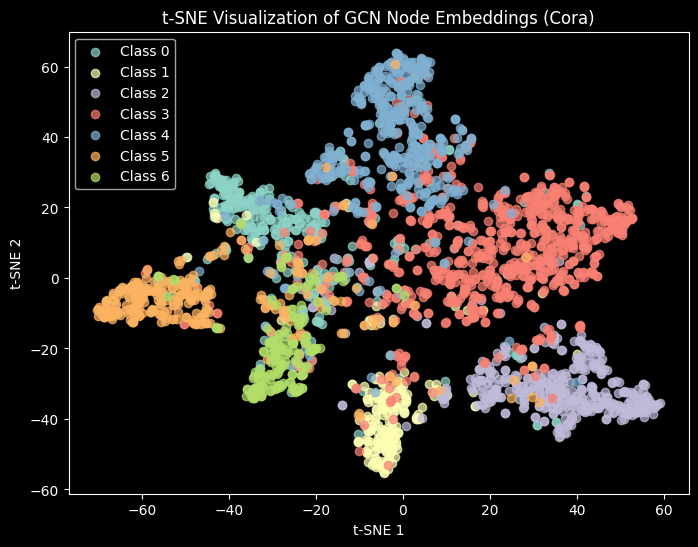

In [11]:
model_cora.eval()
data_Cora, _, num_classes = load_data(Dataset.Cora)
with torch.no_grad():
    embeddings = model_cora(data_Cora.x, data_Cora.edge_index) 

embeddings_np = embeddings.numpy()

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    idx = (data_Cora.y == i).numpy()
    plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=f"Class {i}", alpha=0.7)

plt.legend()
plt.title("t-SNE Visualization of GCN Node Embeddings (Cora)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()
